In [1]:
import tensorflow as tf
from tensorflow.keras import  models, layers
import matplotlib.pyplot as plt

pip install matplotlib

In [2]:
import matplotlib.pyplot as plt

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS = 50

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(256,256),
    batch_size=32
)

Found 5799 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Tomato_Early_blight', 'Tomato_healthy', 'YellowLeaf__Curl_Virus']

In [6]:
len(dataset)

182

In [7]:
211*32

6752

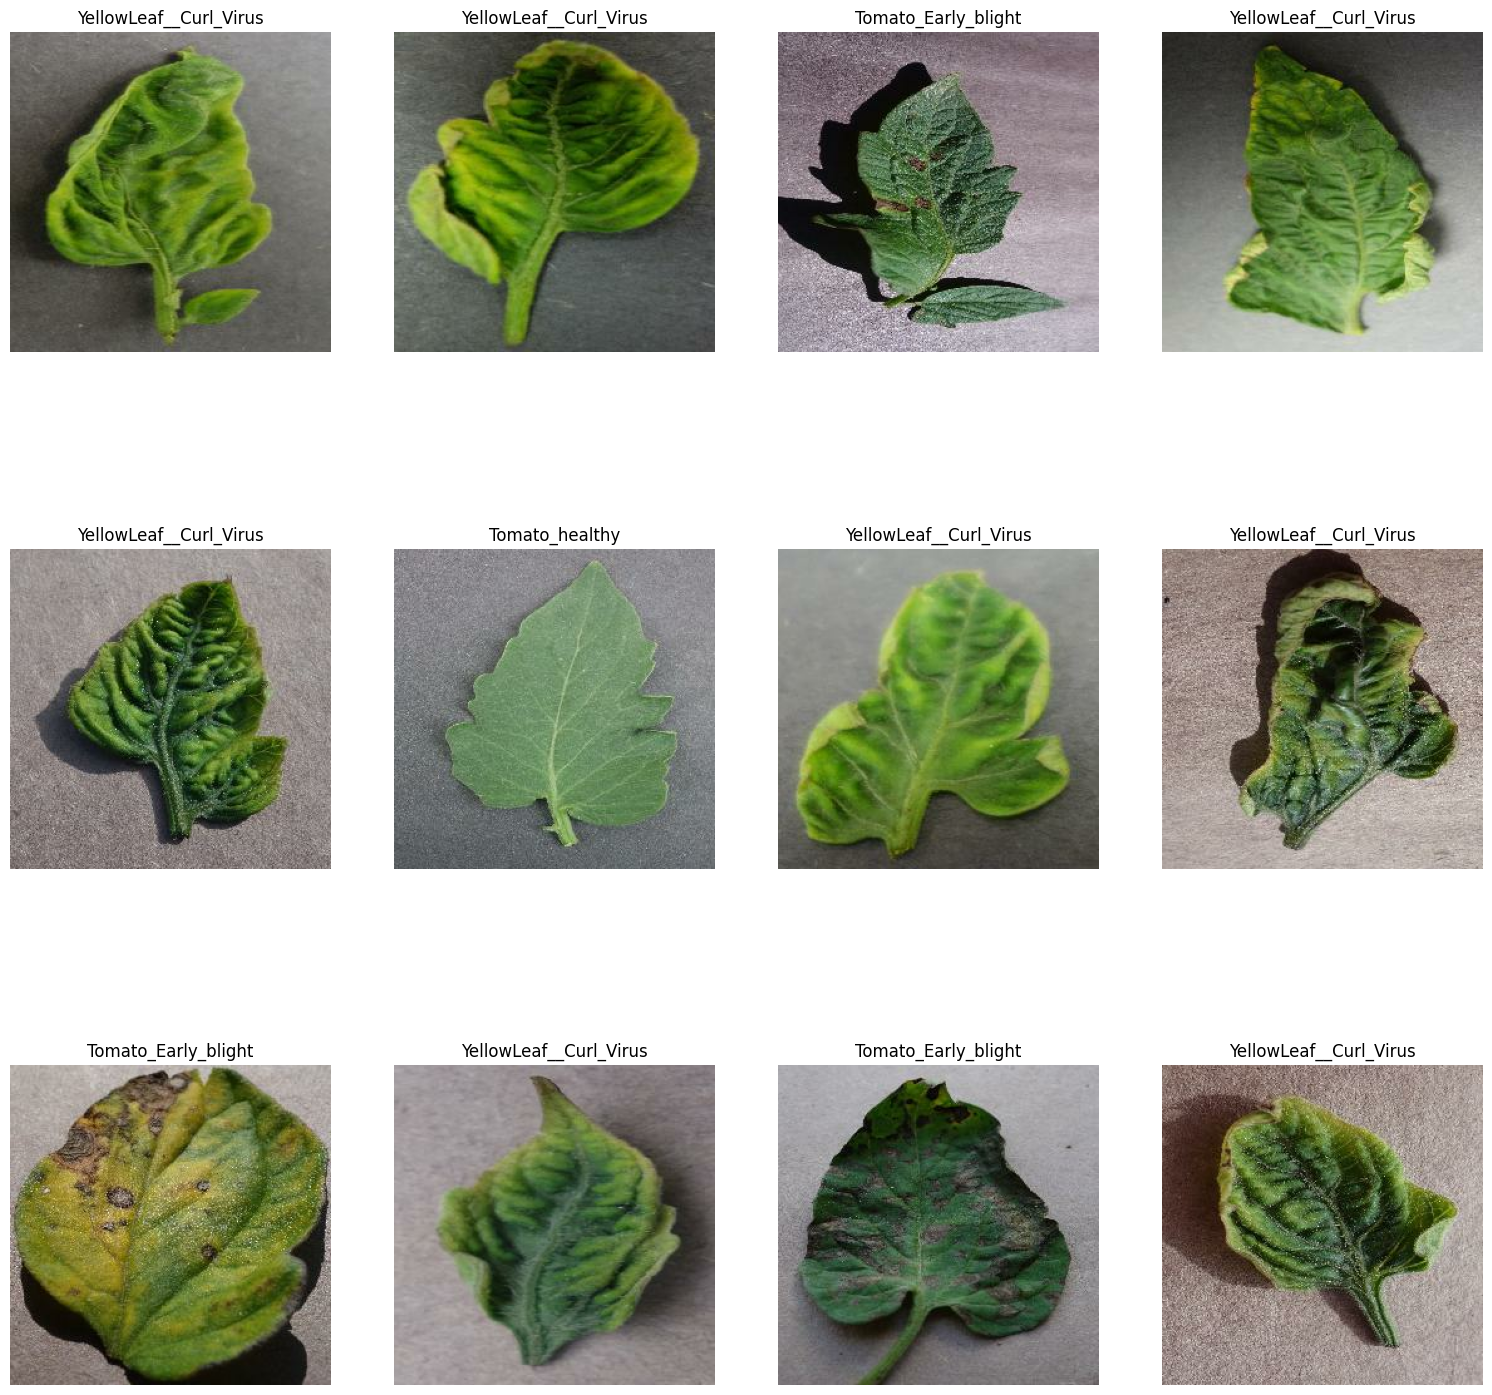

In [8]:
plt.figure(figsize=(19, 19))
for image_batch , label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [9]:
len(dataset)

182

80% ==> training
20% ==> 10% validation , 10% test

In [10]:
train_size  = 0.8
len(dataset)*train_size

145.6

In [11]:
train_ds = dataset.take(168)
len(train_ds)

168

In [12]:
test_ds = dataset.skip(168)
len(test_ds)

14

In [13]:
val_size = 0.1
len(dataset)*val_size

18.2

In [14]:
val_ds = test_ds.take(21)
len(val_ds)

14

In [15]:
test_ds= test_ds.skip(21)
len(test_ds)

0

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

145

In [19]:
len(val_ds)

18

In [20]:
len(test_ds)

19

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
resize_and_rescale =  tf.keras.Sequential([
     layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
     layers.experimental.preprocessing.Rescaling(1./255),
])

In [23]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [24]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [27]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [28]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
145/145 [==============================] - 250s 2s/step - loss: 0.6082 - accuracy: 0.7343 - val_loss: 0.3735 - val_accuracy: 0.8490
Epoch 2/50
145/145 [==============================] - 221s 2s/step - loss: 0.3570 - accuracy: 0.8572 - val_loss: 0.4956 - val_accuracy: 0.8177
Epoch 3/50
145/145 [==============================] - 220s 2s/step - loss: 0.3097 - accuracy: 0.8810 - val_loss: 0.2795 - val_accuracy: 0.8906
Epoch 4/50
145/145 [==============================] - 224s 2s/step - loss: 0.2407 - accuracy: 0.9079 - val_loss: 0.3164 - val_accuracy: 0.9097
Epoch 5/50
145/145 [==============================] - 234s 2s/step - loss: 0.1770 - accuracy: 0.9330 - val_loss: 0.3346 - val_accuracy: 0.8906
Epoch 6/50
145/145 [==============================] - 225s 2s/step - loss: 0.1732 - accuracy: 0.9395 - val_loss: 0.0856 - val_accuracy: 0.9583
Epoch 7/50
145/145 [==============================] - 232s 2s/step - loss: 0.1527 - accuracy: 0.9456 - val_loss: 0.1425 - val_accuracy: 0.9462

In [29]:
scores = model.evaluate(test_ds)

19/19 [==============================] - 30s 359ms/step - loss: 0.0171 - accuracy: 0.9934


In [30]:
scores

[0.017140666022896767, 0.9934210777282715]

In [31]:
history

In [32]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 145}

In [33]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [46]:
history.history['loss']

[0.608238935470581,
 0.3570252060890198,
 0.3096696436405182,
 0.240690678358078,
 0.1769806146621704,
 0.1731632947921753,
 0.15273237228393555,
 0.11560814082622528,
 0.10775187611579895,
 0.09320773929357529,
 0.09040336310863495,
 0.060974426567554474,
 0.051815446466207504,
 0.06256282329559326,
 0.04193951562047005,
 0.06829371303319931,
 0.09745308756828308,
 0.04248141869902611,
 0.051265329122543335,
 0.03761672228574753,
 0.041342128068208694,
 0.04189849644899368,
 0.05194845050573349,
 0.07916259765625,
 0.02692214772105217,
 0.026959391310811043,
 0.02126486971974373,
 0.0213025975972414,
 0.013323808088898659,
 0.045254115015268326,
 0.02144245058298111,
 0.03090619295835495,
 0.018586458638310432,
 0.022678835317492485,
 0.018065620213747025,
 0.006577337626367807,
 0.03381883352994919,
 0.012584298849105835,
 0.011094222776591778,
 0.014025290496647358,
 0.043282732367515564,
 0.023490069434046745,
 0.052480828016996384,
 0.020238904282450676,
 0.02487041987478733,
 0.0

In [35]:
history.history["loss"][:5]

[0.608238935470581,
 0.3570252060890198,
 0.3096696436405182,
 0.240690678358078,
 0.1769806146621704]

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [50]:
score = model.evaluate_generator(test_ds)
print('Test loss : ', score[0])
print('Test accuracy : ', score[1])

C:\Users\Hp\AppData\Local\Temp\ipykernel_4448\245876022.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(test_ds)


Test loss :  0.017140666022896767
Test accuracy :  0.9934210777282715


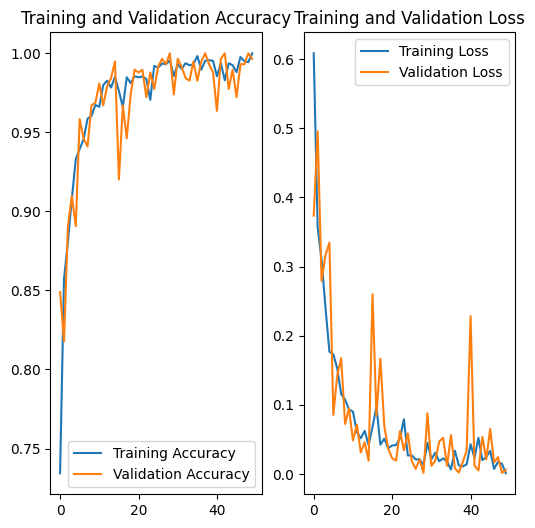

In [53]:
plt.figure(figsize=(6,6))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label : Tomato_Early_blight
1/1 [==============================] - 1s 1s/step
predicted label: Tomato_Early_blight


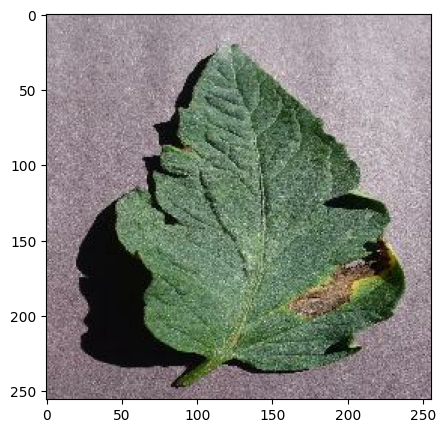

In [38]:
import numpy as np
plt.figure(figsize=(5,5))
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label :",class_names[first_label] )

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
        

In [39]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 55ms/step


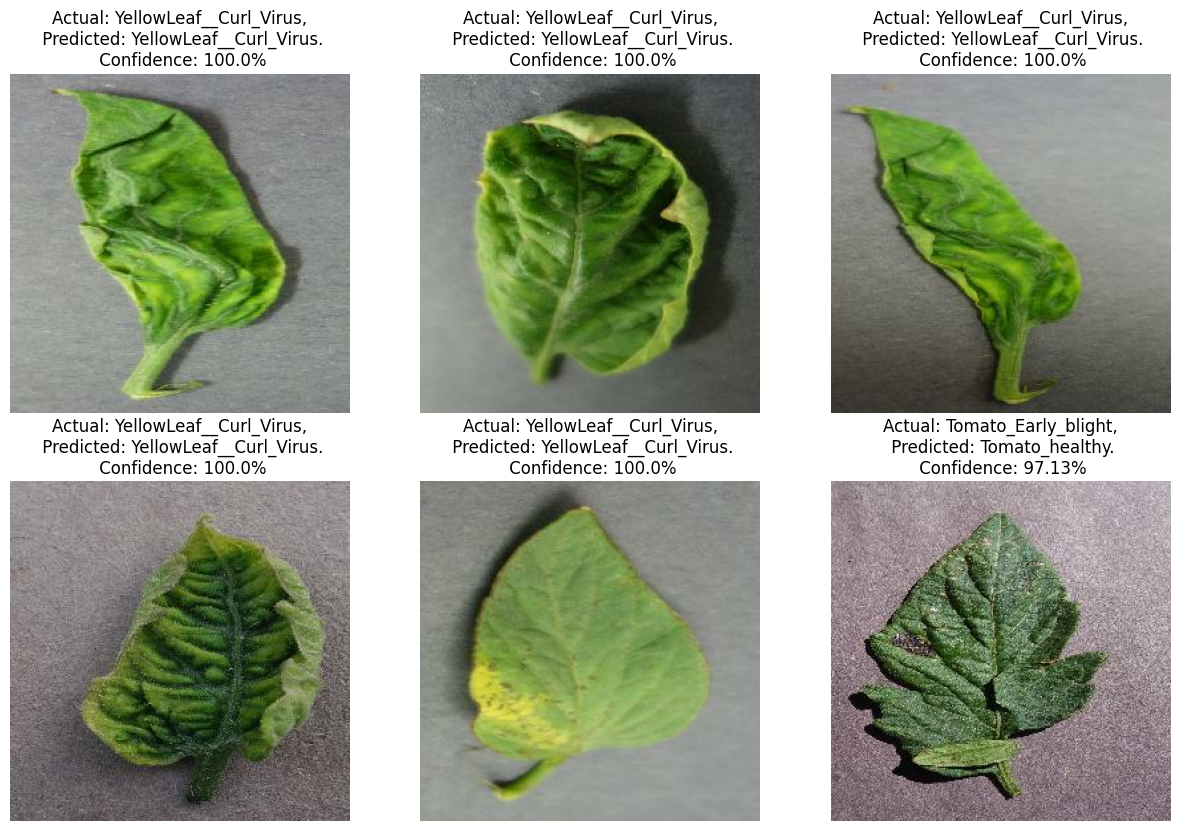

In [40]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [43]:
import os
model_version = max([int(i) for i in os.listdir("../saved_models") + [0]])+1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/3\assets


INFO:tensorflow:Assets written to: ../saved_models/3\assets
